# 02_eda_visualization.ipynb
## EDA, validation, augmentation visualization, and feature extraction for EuroSAT
This notebook runs **after** `01_data_pipeline.ipynb` and expects processed CSVs in `data/processed/` and raw images in `data/raw/EuroSAT/`.


# 1. Environment Setup

In [1]:
# # Install packages (run once)
!pip install --quiet seaborn kaggle opencv-python scikit-image

In [2]:
from google.colab import files
import os

# Upload kaggle.json
print("upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle credentials configured")

upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle credentials configured


### Download and Extract Dataset

In [3]:
# Create folder structure
!mkdir -p data/raw data/interim data/processed data/features src

# Download dataset from Kaggle
!kaggle datasets download -d apollo2506/eurosat-dataset -p data/raw/

# Extract dataset
!unzip -q data/raw/eurosat-dataset.zip -d data/raw/

# verifying what was extracted
if os.path.exists('data/raw'):
    raw_contents = os.listdir('data/raw')
    print(f"data/raw contents: {raw_contents}")

    # Check for EuroSAT folder
    if 'EuroSAT' in raw_contents:
        eurosat_contents = os.listdir('data/raw/EuroSAT')
        print(f"EuroSAT folder contents: {eurosat_contents}")
    else:
        print("EuroSAT folder not found - checking for other folders...")
        for item in raw_contents:
            item_path = f'data/raw/{item}'
            if os.path.isdir(item_path):
                print(f"Found directory: {item}")
                contents = os.listdir(item_path)
                print(f"  Contents: {contents[:5]}...")  # first 5 items

print("Dataset download and extraction complete")


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [00:14<00:00, 251MB/s]
100% 2.04G/2.04G [00:14<00:00, 157MB/s]
data/raw contents: ['eurosat-dataset.zip', 'EuroSATallBands', 'EuroSAT']
EuroSAT folder contents: ['HerbaceousVegetation', 'Forest', 'Residential', 'test.csv', 'SeaLake', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'AnnualCrop', 'validation.csv', 'label_map.json', 'Pasture', 'train.csv']
Dataset download and extraction complete


manually upload the processed files from the previous notebook `01_data_pipeline.ipynb `: (train.csv, test.csv, validation.csv, dataset_statistics.json, label_map.json) into data/processed/.

In [4]:
# Upload processed outputs
uploaded = files.upload()

# Move them into data/processed/
for fname in uploaded.keys():
    os.rename(fname, f"data/processed/{fname}")

print("Uploaded & moved processed files:")
print(os.listdir("data/processed"))
print("Folder structure ready")

Saving dataset_statistics.json to dataset_statistics.json
Saving dataset_statistics.png to dataset_statistics.png
Saving sample_images.png to sample_images.png
Saving test.csv to test.csv
Saving train.csv to train.csv
Saving validation.csv to validation.csv
Uploaded & moved processed files:
['dataset_statistics.json', 'test.csv', 'dataset_statistics.png', 'sample_images.png', 'validation.csv', 'train.csv']
Folder structure ready ✅


In [5]:
print("upload data_pipeline.py :")
uploaded_files = files.upload()

# Move data_pipeline.py to src/
if 'data_pipeline.py' in uploaded_files:
    !mv data_pipeline.py src/
    print("data_pipeline.py moved to src/")
else:
    print("data_pipeline.py not found in uploaded files")

upload data_pipeline.py :


Saving data_pipeline.py to data_pipeline.py
data_pipeline.py moved to src/


In [6]:
# Imports
import os
import sys
import json
import math
import random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps

import cv2
from skimage import feature as skfeature

import torch
from torchvision import transforms
from torchvision.utils import make_grid

# ensure src on path
sys.path.append('src')

# Create output folders if missing
os.makedirs("data/features", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

# Config
RAW_IMG_DIR = Path("data/raw/EuroSAT")
PROCESSED_DIR = Path("data/processed")
FEATURES_DIR = Path("data/features")

# Visualization defaults
sns.set(style="whitegrid")
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# 2. Load Processed Data

In [ ]:
# Load processed CSVs produced by pipeline
expected_csvs = {
    "train": PROCESSED_DIR / "train.csv",
    "validation": PROCESSED_DIR / "validation.csv",
    "test": PROCESSED_DIR / "test.csv"
}

dfs = {}
for split, p in expected_csvs.items():
    if p.exists():
        dfs[split] = pd.read_csv(p)
        print(f"Loaded {split}: {len(dfs[split])} rows")
    else:
        print(f"WARNING: {p} not found. run the pipeline first.")
        dfs[split] = pd.DataFrame()

In [7]:
# Quick column normalization: ensure expected columns exist
def normalize_columns(df):
    if df.empty:
        return df
    cols = df.columns.tolist()
    # tolerant renames
    rename_map = {}
    for c in cols:
        lc = c.strip().lower()
        if lc in ["filename","file","image","file_path","filepath"]:
            rename_map[c] = "Filename"
        if lc in ["label", "label_id", "classid"]:
            rename_map[c] = "Label"
        if lc in ["classname","class_name","class"]:
            rename_map[c] = "ClassName"
    df = df.rename(columns=rename_map)
    return df

for k in list(dfs.keys()):
    dfs[k] = normalize_columns(dfs[k])
    print(f"{k} columns: {list(dfs[k].columns)}")


Loaded train: 18900 rows
Loaded validation: 5400 rows
Loaded test: 2700 rows
train columns: ['Filename', 'Label', 'ClassName', 'full_path']
validation columns: ['Filename', 'Label', 'ClassName', 'full_path']
test columns: ['Filename', 'Label', 'ClassName', 'full_path']


In [8]:
# Validate presence of essential columns --> Ensure CSVs have Filename, Label, ClassName and quick fix
required = ["Filename", "Label", "ClassName"]
for split, df in dfs.items():
    if df.empty:
        continue
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise RuntimeError(f"{split} CSV missing columns: {missing}. Please inspect.")
print("All processed CSVs contain Filename, Label, ClassName")

All processed CSVs contain Filename, Label, ClassName (or are empty).


In [9]:
# Load label_map.json if exists in processed dir or raw
label_map_path = None
for candidate in [PROCESSED_DIR / "label_map.json", RAW_IMG_DIR / "label_map.json"]:
    if candidate.exists():
        label_map_path = candidate
        break

if label_map_path:
    with open(label_map_path, 'r') as f:
        label_map = json.load(f)
    # label_map likely maps names to ints or ints to names; normalize to dict: label->name
    # Try both possibilities
    label_to_name = {}
    if all(isinstance(k, str) for k in label_map.keys()):
        # could be { "AnnualCrop": 0, ... }
        for name, idx in label_map.items():
            label_to_name[int(idx)] = name
    else:
        # else keys might be numeric strings
        for k,v in label_map.items():
            label_to_name[int(k)] = v
    print("Loaded label_map.json:", label_map_path)
    print("Label->ClassName:", label_to_name)
else:
    # Build from train CSV if not present
    if not dfs["train"].empty:
        label_to_name = dfs["train"].set_index("Label")["ClassName"].to_dict()
        print("label_map.json not found; inferred from train CSV")
    else:
        label_to_name = {}
        print("No label_map.json and train CSV missing; label_map unknown")

Loaded label_map.json: data/raw/EuroSAT/label_map.json
Label->ClassName: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


# 3. Class Distributions

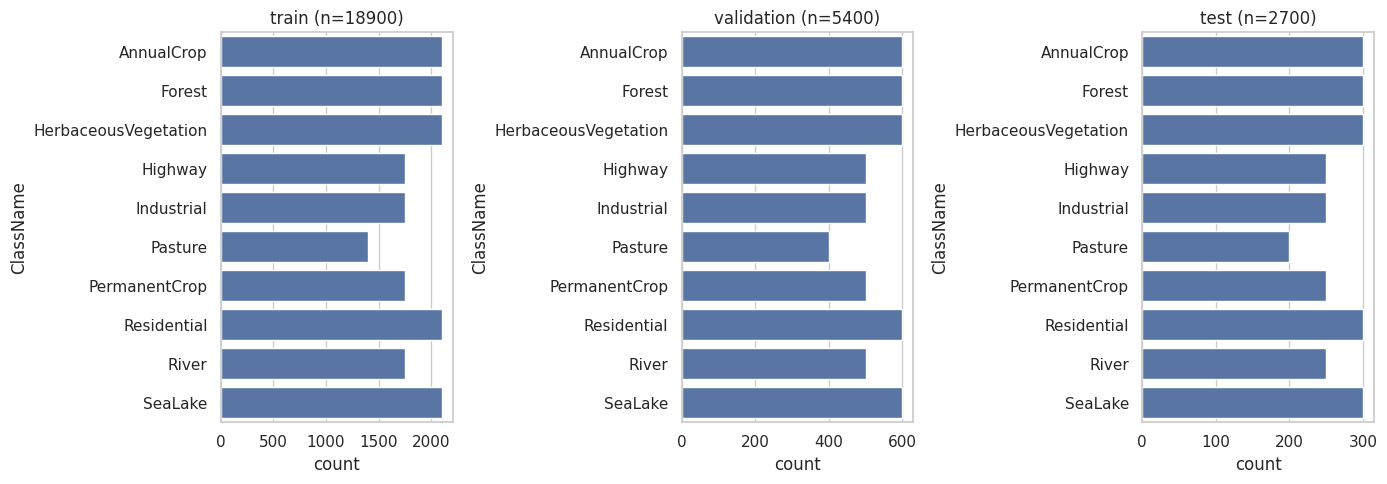

In [10]:
# Plot distributions
plt.figure(figsize=(14,5))
for i,(split, df) in enumerate(dfs.items()):
    if df.empty:
        continue
    plt.subplot(1, len(dfs), i+1)
    order = sorted(df["ClassName"].unique())
    sns.countplot(y="ClassName", data=df, order=order)
    plt.title(f"{split} (n={len(df)})")
plt.tight_layout()


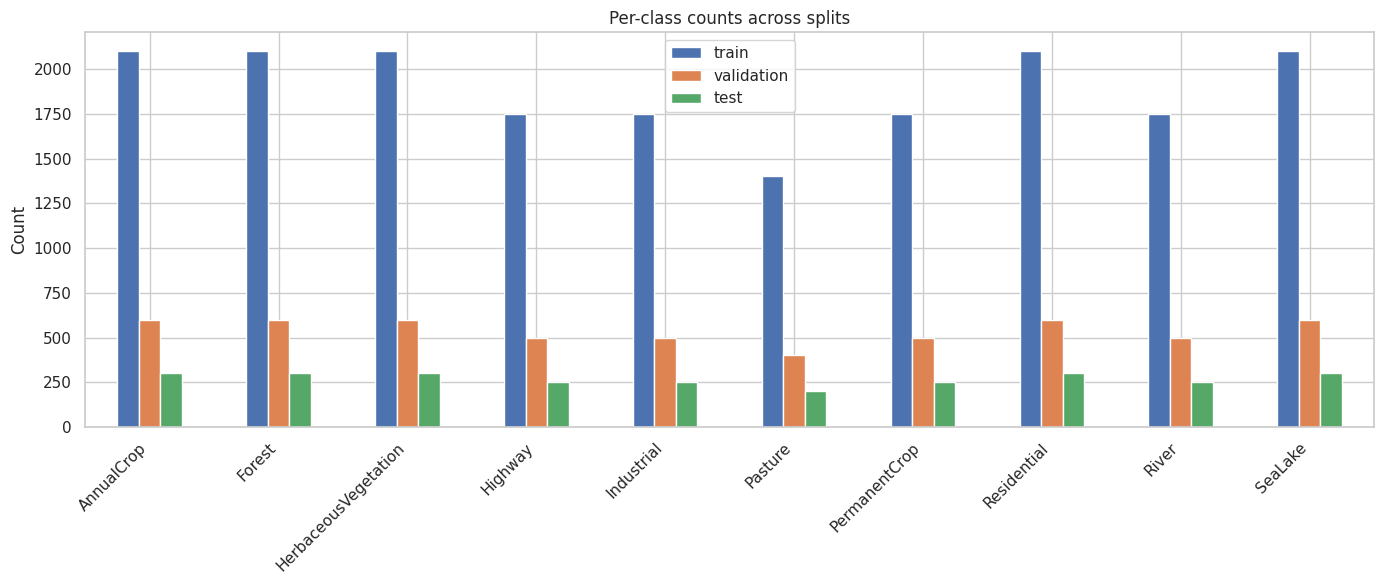

In [11]:
# comparative bar chart: counts per class per split
all_classes = sorted(set().union(*[set(dfs[s]["ClassName"].unique()) for s in dfs if not dfs[s].empty]))
counts = {}
for split, df in dfs.items():
    counts[split] = df["ClassName"].value_counts().reindex(all_classes).fillna(0).astype(int)
comp_df = pd.DataFrame(counts, index=all_classes)
comp_df.plot(kind='bar', figsize=(14,6))
plt.title("Per-class counts across splits")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# 4. Sample Images per Class

In [ ]:
# One sample per class (train preferred, fallback to other splits)
samples = {}
for cls in all_classes:
    found = None
    for split in ["train","validation","test"]:
        if split in dfs and not dfs[split].empty:
            df = dfs[split]
            cand = df[df["ClassName"] == cls]
            if len(cand) > 0:
                found = cand.sample(1).iloc[0]["Filename"]
                break
    if found:
        samples[cls] = found


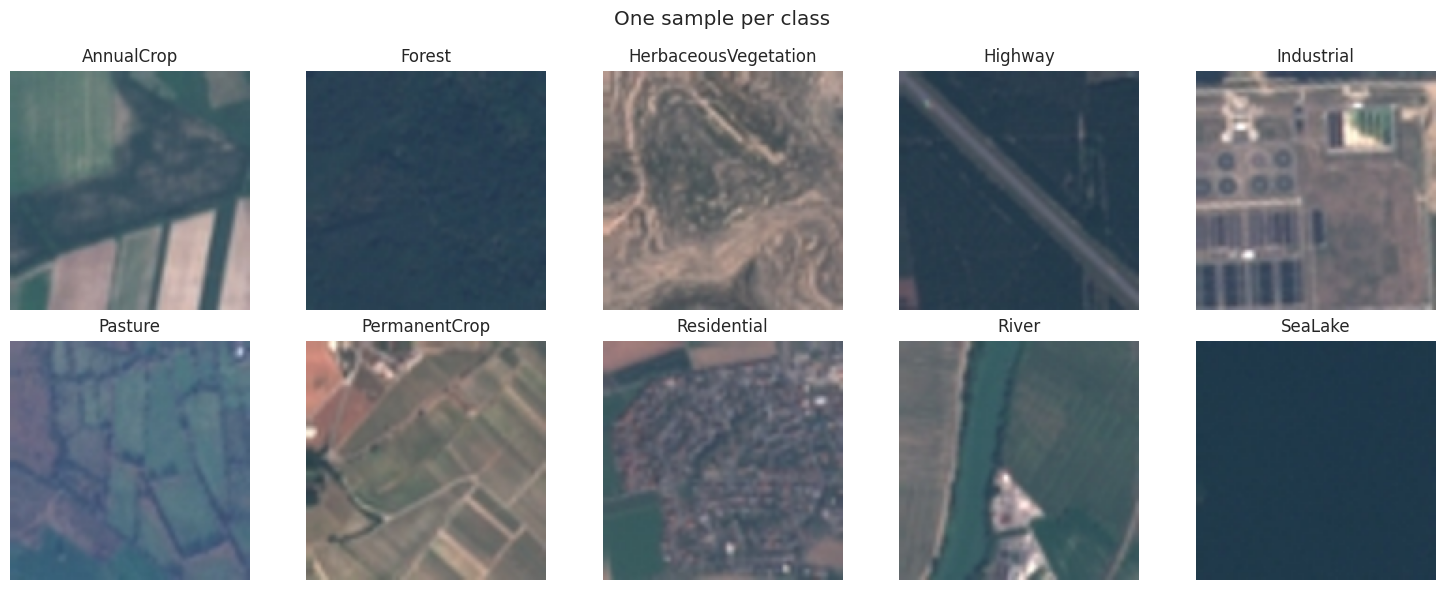

In [12]:
# Plot grid
cols = 5
rows = math.ceil(len(samples)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flat
for i,(cls, fname) in enumerate(samples.items()):
    img_path = RAW_IMG_DIR / fname
    if img_path.exists():
        img = Image.open(img_path).convert("RGB").resize((128,128))
        axes[i].imshow(img)
        axes[i].set_title(cls)
    else:
        axes[i].text(0.5,0.5, "Missing", ha='center')
    axes[i].axis("off")
# hide remaining axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.suptitle("One sample per class")
plt.tight_layout()

# 5. Check for Missing/Corrupted Images

In [13]:
# Check all filenames in CSVs and validate presence & loadability
missing_entries = []
corrupt_entries = []

def try_open(path):
    try:
        img = Image.open(path)
        img.verify()  # will not load data but verifies
        return True
    except Exception:
        return False

for split, df in dfs.items():
    if df.empty: continue
    for i,row in df.iterrows():
        fname = row["Filename"]
        p = RAW_IMG_DIR / fname
        if not p.exists():
            missing_entries.append((split, fname))
        else:
            ok = try_open(p)
            if not ok:
                corrupt_entries.append((split, fname))

print(f"Missing files: {len(missing_entries)}")
print(f"Corrupted files: {len(corrupt_entries)}")

# show some examples (up to 10)
print("Examples missing:", missing_entries[:10])
print("Examples corrupt:", corrupt_entries[:10])


Missing files: 0
Corrupted files: 0
Examples missing: []
Examples corrupt: []


# 6. Handle Anomalies in CSVs

In [14]:
# Remove rows corresponding to missing/corrupt files
for split, df in dfs.items():
    if df.empty: continue
    original_len = len(df)
    mask_exists = df["Filename"].apply(lambda fn: (RAW_IMG_DIR / fn).exists())
    df_clean = df[mask_exists].copy()
    # verify loadability
    cleaned_path = PROCESSED_DIR / f"{split}.csv"
    df_clean.to_csv(cleaned_path, index=False)
    print(f"{split}: {original_len} -> {len(df_clean)} (saved {cleaned_path})")
    dfs[split] = df_clean  # update


train: 18900 -> 18900 (saved data/processed/train.csv)
validation: 5400 -> 5400 (saved data/processed/validation.csv)
test: 2700 -> 2700 (saved data/processed/test.csv)


In [ ]:
# Find duplicate filenames across splits
filename_to_splits = defaultdict(list)
for split, df in dfs.items():
    if df.empty: continue
    for fn in df["Filename"].tolist():
        filename_to_splits[fn].append(split)

dupes = {fn:splits for fn,splits in filename_to_splits.items() if len(splits)>1}
print(f"Found {len(dupes)} filenames present in more than one split")

In [ ]:
# keep in train if present; otherwise keep in first split found.
removed_rows = []
for fn, splits in dupes.items():
    # keep in 'train' else keep in first split, remove from others
    keep = "train" if "train" in splits else splits[0]
    for s in splits:
        if s == keep: continue
        # remove rows with Filename==fn in dfs[s]
        prev_len = len(dfs[s])
        dfs[s] = dfs[s][dfs[s]["Filename"] != fn].copy()
        if len(dfs[s]) != prev_len:
            removed_rows.append((fn, s))
len_removed = len(removed_rows)
print(f"Removed {len_removed} duplicate rows from non-kept splits (kept in train where possible)")

In [15]:
# Save cleaned CSVs again
for split, df in dfs.items():
    if df.empty: continue
    p = PROCESSED_DIR / f"{split}.csv"
    df.to_csv(p, index=False)
    print(f"Saved cleaned {split} -> {p} ({len(df)} rows)")


Found 0 filenames present in more than one split
Removed 0 duplicate rows from non-kept splits (kept in train where possible)
Saved cleaned train -> data/processed/train.csv (18900 rows)
Saved cleaned validation -> data/processed/validation.csv (5400 rows)
Saved cleaned test -> data/processed/test.csv (2700 rows)


# 7. Ensure Consistent Labels

In [ ]:
# Cross-check class names against label_to_name mapping
mapped_names = set(label_to_name.values()) if label_to_name else set()
csv_names = set().union(*[set(dfs[s]["ClassName"].unique()) for s in dfs if not dfs[s].empty])

print("Classes in CSVs:", sorted(csv_names))
print("Classes in label_map:", sorted(mapped_names))

In [ ]:
# If mismatch, try to fix by trimming whitespace and case normalization
def normalize_name(x):
    return str(x).strip()

fixes = {}
for split, df in dfs.items():
    if df.empty: continue
    df["ClassName"] = df["ClassName"].apply(normalize_name)
    dfs[split] = df

# Recompute sets
csv_names = set().union(*[set(dfs[s]["ClassName"].unique()) for s in dfs if not dfs[s].empty])
print("Post-normalization classes in CSVs:", sorted(csv_names))

In [16]:
# If label_map missing or inconsistent, regenerate label_map.json in processed dir
if not label_to_name or set(label_to_name.values()) != csv_names:
    # create deterministic mapping sorted by name
    class_list = sorted(list(csv_names))
    new_map = {str(i): name for i,name in enumerate(class_list)}
    # Save label_map.json (map index->name)
    with open(PROCESSED_DIR / "label_map.json", "w") as f:
        json.dump(new_map, f, indent=2)
    # also create numeric label column if missing
    class_to_label = {v:int(k) for k,v in new_map.items()}
    for split, df in dfs.items():
        if df.empty: continue
        # create numeric Label column from ClassName
        df["Label"] = df["ClassName"].map(class_to_label)
        dfs[split] = df
    print("Generated new label_map.json and updated numeric labels")
else:
    print("label_map.json is consistent with CSV classes")

Classes in CSVs: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Classes in label_map: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Post-normalization classes in CSVs: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
label_map.json is consistent with CSV classes


# 8. Pixel Intensity Distribution

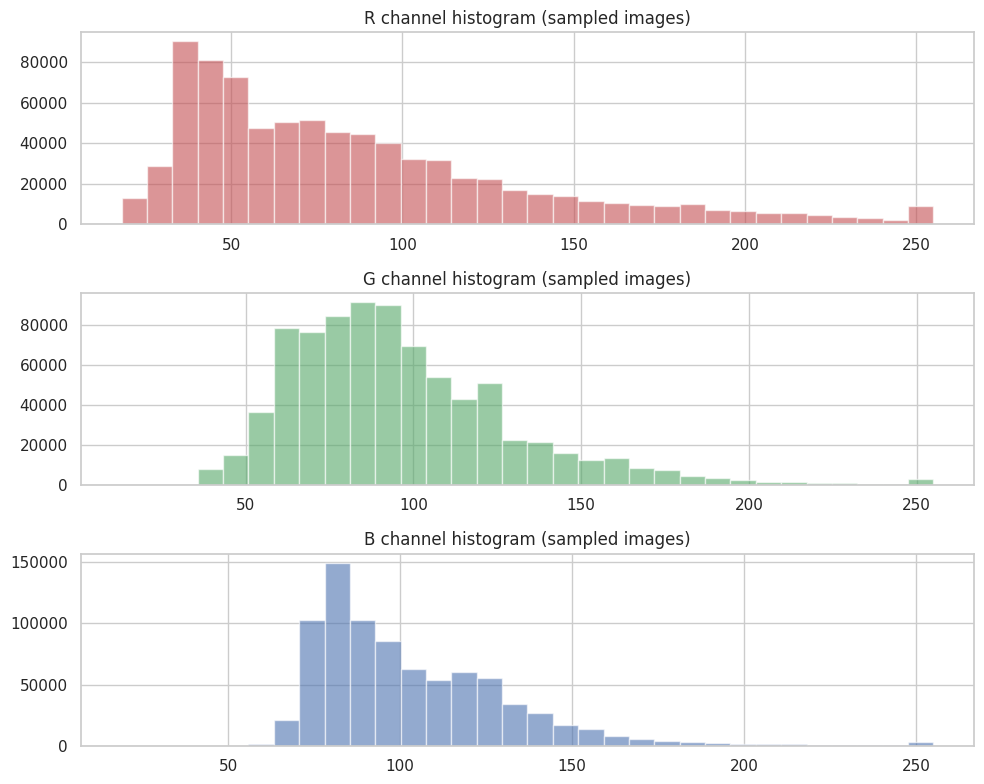

In [17]:
# sample up to N images for histogram (balanced across classes)
N_PER_CLASS = 20
sampled_paths = []
for cls in sorted(csv_names):
    # gather list across splits
    all_fns = []
    for split, df in dfs.items():
        if df.empty: continue
        all_fns += df[df["ClassName"]==cls]["Filename"].tolist()
    # sample
    chosen = random.sample(all_fns, min(N_PER_CLASS, len(all_fns))) if all_fns else []
    sampled_paths += [(cls, RAW_IMG_DIR/fn) for fn in chosen]

# build histograms
bins = 32
fig, axs = plt.subplots(3,1, figsize=(10,8))
colors = ['r','g','b']
for i,c in enumerate(colors):
    channel_vals = []
    for cls,p in sampled_paths:
        try:
            img = np.array(Image.open(p).convert("RGB"))
            channel_vals.append(img[:,:,i].ravel())
        except:
            continue
    if len(channel_vals)==0:
        continue
    all_vals = np.concatenate(channel_vals)
    axs[i].hist(all_vals, bins=bins, color=c, alpha=0.6)
    axs[i].set_title(f"{['R','G','B'][i]} channel histogram (sampled images)")
plt.tight_layout()


# 9. upload the Augmentation Functions `src/features.py`

In [18]:
uploaded = files.upload()

import os, shutil
os.makedirs("src", exist_ok=True)
shutil.move("features.py", "src/features.py")
print("features.py moved to src/")

Wrote src/features.py with augmentation functions


In [ ]:
# import the augmentation functions
from src.features import geo_safe_augmentations, basic_preprocess

aug = geo_safe_augmentations()
pre = basic_preprocess()


# 10. Visualize Augmentations

Saved augmentation_examples.png


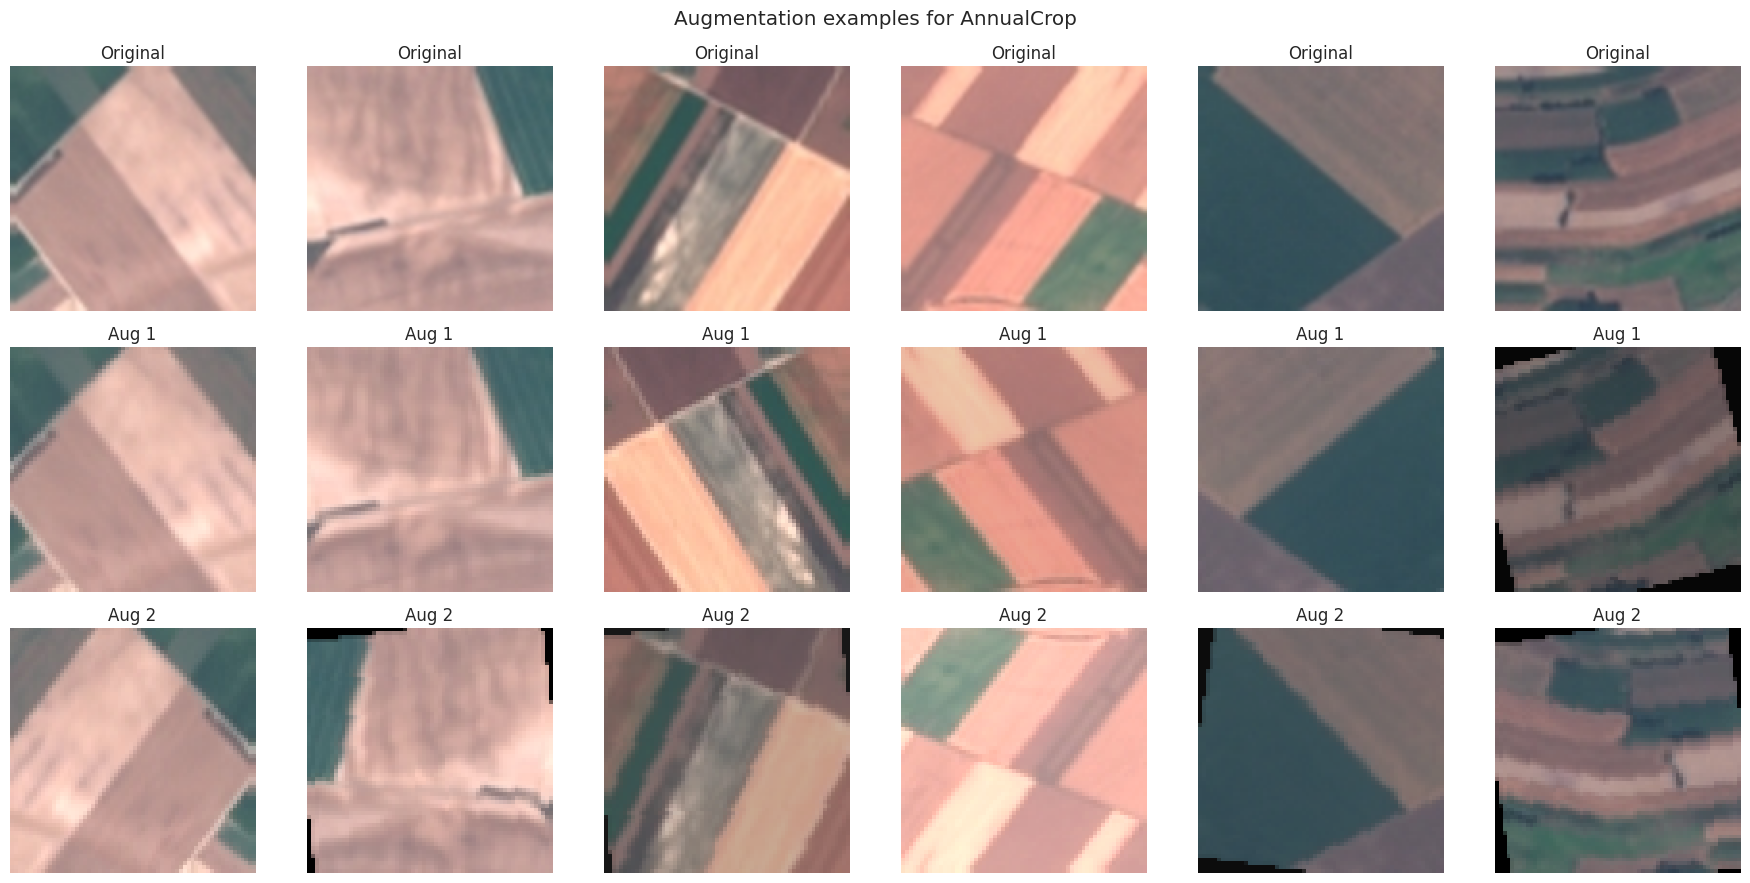

In [19]:
# show augmentations for a small set of images (one class)
example_cls = next(iter(sorted(csv_names)))
example_fns = []
for split in ['train','validation','test']:
    if split in dfs and not dfs[split].empty:
        example_fns = dfs[split][dfs[split]["ClassName"]==example_cls]["Filename"].tolist()
        if example_fns: break

example_fns = example_fns[:6]
fig, axes = plt.subplots(3, 6, figsize=(18,9))
for i, fn in enumerate(example_fns):
    img = Image.open(RAW_IMG_DIR / fn).convert("RGB")
    axes[0,i].imshow(img.resize((128,128)))
    axes[0,i].set_title("Original")
    axes[0,i].axis("off")
    # show 2 augmentations
    for j in range(1,3):
        augmented = aug(img)
        # augmented is tensor C,H,W -> convert
        aug_np = augmented.permute(1,2,0).numpy().clip(0,1)
        axes[j,i].imshow(aug_np)
        axes[j,i].set_title(f"Aug {j}")
        axes[j,i].axis("off")
plt.suptitle(f"Augmentation examples for {example_cls}")
plt.tight_layout()
# save visualization
plt.savefig(PROCESSED_DIR / "augmentation_examples.png", dpi=200, bbox_inches='tight')
print("Saved augmentation_examples.png")


# 11. Class-Level Statistics

In [ ]:
# compute mean RGB per class using up to SAMPLES_PER_CLASS images
SAMPLES_PER_CLASS = 200  # set lower if speed/memory limited
class_stats = []
for cls in sorted(csv_names):
    # gather file list
    all_fns = []
    for split, df in dfs.items():
        if df.empty: continue
        all_fns += df[df["ClassName"]==cls]["Filename"].tolist()
    sample = random.sample(all_fns, min(SAMPLES_PER_CLASS, len(all_fns)))
    if not sample:
        continue
    pixels = np.zeros(3, dtype=np.float64)
    total = 0
    for fn in sample:
        p = RAW_IMG_DIR / fn
        try:
            img = np.array(Image.open(p).convert("RGB")).astype(np.float32) / 255.0
            mean_rgb = img.mean(axis=(0,1))
            pixels += mean_rgb
            total += 1
        except:
            continue
    if total > 0:
        avg_rgb = (pixels / total).tolist()
    else:
        avg_rgb = [None,None,None]
    class_stats.append({"Class": cls, "Mean_R": avg_rgb[0], "Mean_G": avg_rgb[1], "Mean_B": avg_rgb[2], "Samples": total})

In [20]:
class_stats_df = pd.DataFrame(class_stats)
class_stats_df.to_csv(FEATURES_DIR / "class_mean_rgb.csv", index=False)
with open(FEATURES_DIR / "class_mean_rgb.json","w") as f:
    json.dump(class_stats, f, indent=2)
print("Saved class-level mean RGB to data/features/class_mean_rgb.csv/json")
class_stats_df


Saved class-level mean RGB to data/features/class_mean_rgb.csv/json


,Class,Mean_R,Mean_G,Mean_B,Samples
0,AnnualCrop,0.500410,0.467418,0.458025,200
1,Forest,0.151665,0.250707,0.295207,200
2,HerbaceousVegetation,0.375902,0.377845,0.398084,200
3,Highway,0.341524,0.375089,0.400972,200
4,Industrial,0.463353,0.477347,0.515659,200
5,Pasture,0.241583,0.345635,0.367086,200
6,PermanentCrop,0.479804,0.456056,0.446520,200
7,Residential,0.401134,0.411149,0.445231,200
8,River,0.259941,0.339943,0.379100,200
9,SeaLake,0.185918,0.283732,0.346092,200


* For each image in processed train/validation/test (optionally sample), compute features:



In [ ]:
# Color histogram (16 bins per channel -> 48 dims) + texture: mean LBP histogram bins (16) + edge density -> vector saved

HIST_BINS = 16
LBP_POINTS = 24
LBP_RADIUS = 3
MAX_IMAGES = 5000  # set to None to do all images

os.makedirs(FEATURES_DIR, exist_ok=True)
feature_rows = []
processed_count = 0

In [ ]:
def color_hist_features(img_np, bins=HIST_BINS):
    # img_np: H,W,3 uint8
    feats = []
    for ch in range(3):
        h = cv2.calcHist([img_np], [ch], None, [bins], [0,256]).ravel()
        h = h / (h.sum() + 1e-9)
        feats.extend(h.tolist())
    return feats

In [ ]:
def texture_features(img_np, lbp_points=LBP_POINTS, lbp_radius=LBP_RADIUS, hist_bins=16):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    lbp = skfeature.local_binary_pattern(gray, lbp_points, lbp_radius, method="uniform")
    # histogram of LBP
    max_bins = int(lbp.max() + 1)
    h, _ = np.histogram(lbp.ravel(), bins=hist_bins, range=(0, hist_bins))
    h = h / (h.sum()+1e-9)
    # edge density via Sobel
    sobx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    soby = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(sobx**2 + soby**2)
    edge_density = (mag > 50).sum() / (mag.size + 1e-9)
    return h.tolist(), edge_density

In [ ]:
# iterate splits and images (sampled)
for split, df in dfs.items():
    if df.empty: continue
    # option to sample within split to cap total
    file_list = df["Filename"].tolist()
    if MAX_IMAGES and len(file_list) > MAX_IMAGES:
        file_list = random.sample(file_list, MAX_IMAGES)
    for fn in file_list:
        path = RAW_IMG_DIR / fn
        if not path.exists(): continue
        try:
            img = np.array(Image.open(path).convert("RGB").resize((128,128)))
            ch_feats = color_hist_features(img)
            lbp_hist, edge_density = texture_features(img)
            row = {
                "split": split,
                "Filename": fn,
                "ClassName": df[df["Filename"]==fn]["ClassName"].iloc[0],
                "Label": int(df[df["Filename"]==fn]["Label"].iloc[0]) if "Label" in df.columns else None,
            }
            # add features
            for i,v in enumerate(ch_feats):
                row[f"colhist_{i}"] = float(v)
            for i,v in enumerate(lbp_hist):
                row[f"lbp_{i}"] = float(v)
            row["edge_density"] = float(edge_density)
            feature_rows.append(row)
            processed_count += 1
        except Exception as e:
            # skip problematic images
            continue
    print(f"Processed features for split {split}, total processed so far: {processed_count}")
    if MAX_IMAGES and processed_count >= MAX_IMAGES:
        break

# 12. Extract Image-Level Features & Save

In [21]:
# Save features to CSV
feat_df = pd.DataFrame(feature_rows)
feat_path = FEATURES_DIR / "image_features.csv"
feat_df.to_csv(feat_path, index=False)
print(f"Saved {processed_count} image feature rows to {feat_path}")

Processed features for split train, total processed so far: 5000
Saved 5000 image feature rows to data/features/image_features.csv


In [24]:
# Save distribution plots
for split, df in dfs.items():
    if df.empty:
        continue
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x="ClassName", order=sorted(df["ClassName"].unique()))
    plt.title(f"Class Distribution in {split}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR / f"class_distribution_{split}.png", dpi=200, bbox_inches='tight')
    plt.close()
    print(f"Saved class_distribution_{split}.png")

Saved class_distribution_train.png ✅
Saved class_distribution_validation.png ✅
Saved class_distribution_test.png ✅


In [22]:
# Final save of cleaned CSVs (already updated dfs earlier)
for split, df in dfs.items():
    if df.empty: continue
    out = PROCESSED_DIR / f"{split}.csv"
    df.to_csv(out, index=False)
    print(f"Saved cleaned {split} -> {out} ({len(df)} rows)")


Saved cleaned train -> data/processed/train.csv (18900 rows)
Saved cleaned validation -> data/processed/validation.csv (5400 rows)
Saved cleaned test -> data/processed/test.csv (2700 rows)


In [23]:
print("=== EDA & Feature Extraction SUMMARY ===")
print(f"Processed CSVs saved in: {PROCESSED_DIR}")
print(f"Feature files saved to: {FEATURES_DIR}")
print("Files present:")
for p in sorted(list(PROCESSED_DIR.glob("*"))):
    print(" -", p.name)
for p in sorted(list(FEATURES_DIR.glob("*"))):
    print(" -", p.name)
print("\nDone. You can now continue to model training using data/processed/ CSVs and features in data/features/")


=== EDA & Feature Extraction SUMMARY ===
Processed CSVs saved in: data/processed
Feature files saved to: data/features
Files present:
 - augmentation_examples.png
 - dataset_statistics.json
 - dataset_statistics.png
 - sample_images.png
 - test.csv
 - train.csv
 - validation.csv
 - class_mean_rgb.csv
 - class_mean_rgb.json
 - image_features.csv

Done. You can now continue to model training using data/processed/ CSVs and features in data/features/
